In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import scipy.signal as signal
import pandas as pd
from os.path import join
from kam11 import context, matchedFilter, thermister, rayModeling
from beamforming import curvedWaveFront, timeDomain, beam_correlations
from kam11.plotting import mfPlotting
from kam11.plotting import beamformer as beam_plotting
from kam11.helper import baseband

In [2]:
timeOfInterest='2011 J184 03:51:15'
loadDuration=dt.timedelta(0,5)
tof = dt.datetime.strptime(timeOfInterest, '%Y J%j %H:%M:%S')
ssp=thermister.getSoundSpeed(tof)

probeBounds = (-4.5, -4.1955)  # time bounds on lowest receiver
synth_angle = 6.25  # degrees
thetaRange=(0,8)
numTheta=300
beamformingRange=(-3,2)
numBeams=301
snap_index = 10
uprate = 5
look_theta = np.r_[thetaRange[0]:thetaRange[1]:numTheta*1j]
look_tau = np.r_[beamformingRange[0]:beamformingRange[1]:numBeams*1j]

In [3]:
mf = matchedFilter.mf_bytime(tof, loadDuration, baseband=False)
test_delay=curvedWaveFront.getDelays(look_theta, ssp, mf.rd, mf.rd[1])

ts, mf_time = mf.single_index(snap_index)
#create simulated data
timeI = (ts.index > min(probeBounds)) & (ts.index < max(probeBounds))
testSignal=ts.ix[timeI, ts.columns[0]]

synth_delay = curvedWaveFront.getDelays(synth_angle, ssp, mf.rd, mf.rd[1])

#create synthetic data set
synth_ts = np.zeros(ts.shape).T
for i, j in enumerate(np.squeeze(np.array(synth_delay))):
    timeI = ts.index >= j
    timeI = np.argmax(timeI)
    synth_ts[i, timeI:timeI+testSignal.size] = testSignal

#bandpass signal to bw of data
nfilter = 256
b = signal.remez(nfilter, [0, 9000, 11500, 34500, 37000, 50000],
                 [0,1,0], Hz = 1e5)
b = np.array(b, ndmin = 2)
synth_ts = signal.convolve(synth_ts, b, 'same')

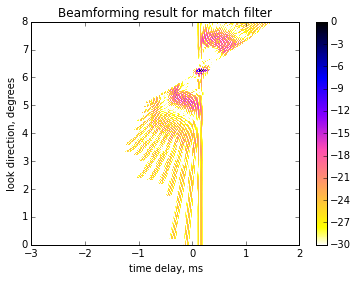

In [4]:
beamformer = timeDomain.ShiftAndAdd(synth_ts.T,
                                    tAxis=ts.index, upsample=5)
bf = beamformer.beamform(look_tau, test_delay)
ax=beam_plotting.plot_beamformer(look_theta, look_tau, bf, vmin=-30)

In [5]:
ts_max = beamformer.beamform(np.array(ts.index), synth_delay)
maxAngle = beam_correlations.maxangle(bf, (-2, 2), (4,8))
beamMax = bf[bf.columns.asof(maxAngle)]

In [6]:
#Bounds picked out of a plot
beam_bounds = (-0.05, 0.5)
est_beam = beamMax[(beamMax.index > min(beam_bounds)) &
                  (beamMax.index < max(beam_bounds))]

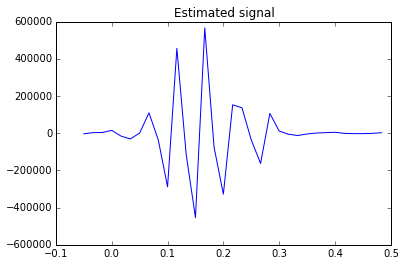

In [7]:
_=plt.plot(est_beam.index, np.real(est_beam))
_=plt.title('Estimated signal')

In [20]:
%autoreload
beamcorr = beam_correlations.correlate_signal(synth_ts.T,
                                              est_beam, taxis=ts.index)
# beamcorr['tau'] -= beamcorr['tau'][0]

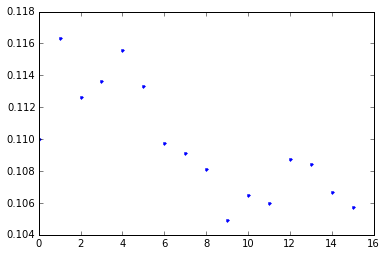

In [21]:
timeDiff = np.array(beamcorr['tau']) -\
    np.array(curvedWaveFront.getDelays(maxAngle, ssp, mf.rd, mf.rd[1]))
_=plt.plot(np.squeeze(timeDiff),'.')

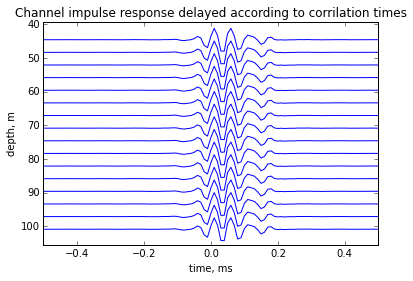

In [24]:
plot_ts = pd.DataFrame(synth_ts.T, index = ts.index, columns = ts.columns)
ax = mfPlotting.plotSingleTime(plot_ts, isDB = False, vmin=-3e4,
                          vmax = 3e4, tStart=-0.5, tEnd = 0.5,
                         channel_delays=np.array(beamcorr['tau']))
_ = ax.set_title('Channel impulse response delayed according to corrilation times')

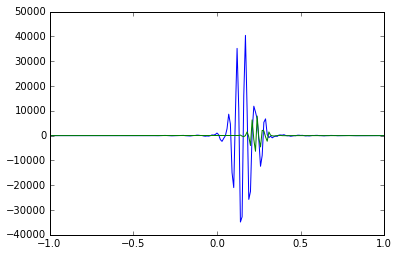

In [35]:
eraser = np.zeros(synth_ts.shape[1])
eraserI = np.argmin(np.abs(ts.index - np.array(beamcorr['tau'])[0]))
eraser[eraserI:eraserI+est_beam.size] = np.real(est_beam) * beamcorr['amp'][0]
# _=plt.plot(ts.index, synth_ts[0,:] + eraser)
_=plt.plot(ts.index, synth_ts[0,:])
_=plt.plot(ts.index, eraser)
_=plt.xlim(-1,1)

In [34]:
eraserI

0